# 全连接卷积神经网络-FCN

采用卷积神经网络实现了从图像像素到像素类别的变换

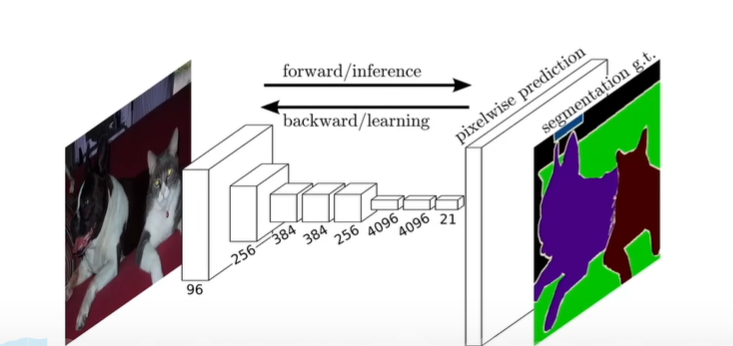

全卷积网络将中间层特征图的高和宽变换回输入图像的尺寸（通过转置卷积来实现）

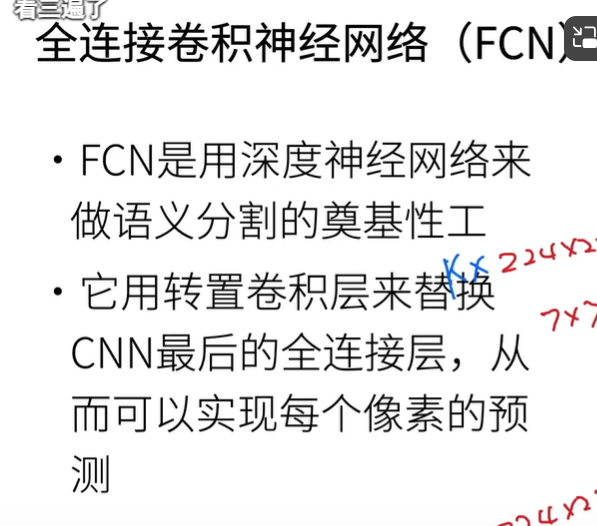

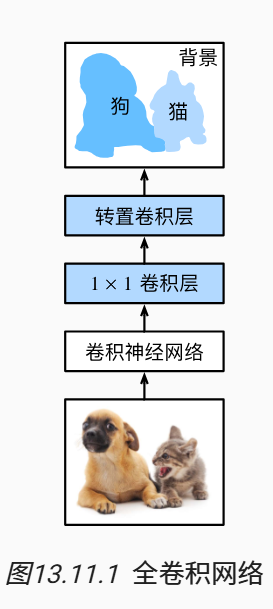

全卷积网络先使用卷积神经网络抽取图像特征，然后通过1×1卷积层将通道数变换为类别个数，最后通过转置卷积层将特征图的高和宽变换为输入图像的尺寸。 因此，模型输出与输入图像的高和宽相同，且最终输出通道包含了该空间位置像素的类别预测。


FCN去掉了全连接层，完全由卷积层和上采样层（反卷积层）组成

这样可以处理任意大小的输入图像，并生成与输入图像大小相同的分割图。FCN特别适合语义分割任务，即将图像中的每个像素分类到一个特定的类别。

FCN的主要特点包括：

卷积层（Convolutional Layer）：

类似于传统的CNN，使用卷积操作提取特征。
池化层（Pooling Layer）：

降低特征图的尺寸，提取更高级别的特征。
上采样层（Upsampling Layer）：

使用反卷积（转置卷积）或插值方法将低分辨率的特征图恢复到原始图像的大小。
跳跃连接（Skip Connection）：

在不同层之间添加连接，以结合不同尺度的特征，有助于生成更精确的分割结果。

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
#使用ImageNet数据集上预训练的ResNet-18模型来提取图像特征

pretrained_net = torchvision.models.resnet18(pretrained=True)
list(pretrained_net.children())[-3:]

# 倒数两层是不需要的 即没有全连接层

[Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (downsample): Sequential(
       (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
   )
   (1): BasicBlock(
     (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): Batc

In [4]:
net = nn.Sequential(*list(pretrained_net.children())[:-2])

In [5]:
net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [9]:
X = torch.rand(size=(1, 3, 320, 480))

#高宽320x480 1为批处理大小 3为通道数

net(X).shape

torch.Size([1, 512, 10, 15])

In [10]:
# 设置类别数量，通常用于分类任务
num_classes = 21

# 向网络中添加一个卷积层
# 这个卷积层将输入通道数为 512 的特征图转换为 num_classes（21）个输出通道
# kernel_size=1 表示使用 1x1 的卷积核，这种卷积通常用于降维或改变通道数
net.add_module('final_conv', nn.Conv2d(512, num_classes, kernel_size=1))

# 向网络中添加一个转置卷积层
# 这个转置卷积层将输入通道数为 num_classes（21） 的特征图转换为同样的通道数
# kernel_size=64 表示使用 64x64 的卷积核，stride=32 表示步幅设置为 32，padding=16 表示在输入特征图周围添加 16 像素的零填充
net.add_module('transpose_conv', nn.ConvTranspose2d(num_classes, num_classes,
                                    kernel_size=64, padding=16, stride=32))

In [11]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    # 计算滤波器的中心点因子
    factor = (kernel_size + 1) // 2
    
    # 如果卷积核大小为奇数，则中心点为 factor - 1
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        # 如果卷积核大小为偶数，则中心点为 factor - 0.5
        center = factor - 0.5
    
    # 创建一个网格，用于生成双线性插值核的坐标
    og = (torch.arange(kernel_size).reshape(-1, 1), 
          torch.arange(kernel_size).reshape(1, -1))
          
    # 计算卷积核的双线性插值值
    filt = (1 - torch.abs(og[0] - center) / factor) * \
           (1 - torch.abs(og[1] - center) / factor)

    # 初始化权重为零的四维张量
    weight = torch.zeros((in_channels, out_channels, 
                          kernel_size, kernel_size))
    
    # 将计算出来的滤波器值赋给适当的通道
    weight[range(in_channels), range(out_channels), :, :] = filt
    
    # 返回生成的双线性插值卷积核权重
    return weight

input image shape: torch.Size([561, 728, 3])
output image shape: torch.Size([1122, 1456, 3])


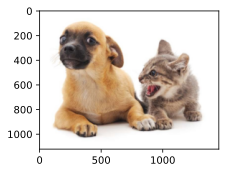

In [15]:
conv_trans = nn.ConvTranspose2d(3, 3, kernel_size=4, padding=1, stride=2,
                                bias=False)
# 双线性插值的上采样初始化转置卷积层。
conv_trans.weight.data.copy_(bilinear_kernel(3, 3, 4));

img = torchvision.transforms.ToTensor()(d2l.Image.open('catdog.jpg'))
X = img.unsqueeze(0)
#X进行转置卷积操作得到Y
Y = conv_trans(X)
out_img = Y[0].permute(1, 2, 0).detach()

d2l.set_figsize()
print('input image shape:', img.permute(1, 2, 0).shape)
d2l.plt.imshow(img.permute(1, 2, 0));
print('output image shape:', out_img.shape)
d2l.plt.imshow(out_img);

In [16]:
# 全卷积网络用双线性插值的上采样初始化转置卷积层。
# 对于卷积层，我们使用Xavier初始化参数。
W = bilinear_kernel(num_classes, num_classes, 64)
net.transpose_conv.weight.data.copy_(W);

In [17]:
# 分配训练集与测试集数据

batch_size, crop_size = 32, (320, 480)
train_iter, test_iter = d2l.load_data_voc(batch_size, crop_size)

read 1114 examples
read 1078 examples


loss 0.413, train acc 0.870, test acc 0.852
114.4 examples/sec on [device(type='cuda', index=0)]


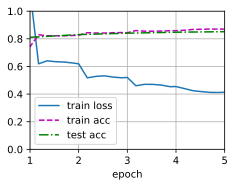

In [18]:
# 定义损失函数
def loss(inputs, targets):
    # 使用交叉熵损失函数计算输入与目标之间的损失
    # 'reduction' 设置为 'none'，返回不聚合的损失，即保留每个样本的损失
    return F.cross_entropy(inputs, targets, reduction='none').mean(1).mean(1)

# 设置训练的一些超参数
num_epochs, lr, wd, devices = 5, 0.001, 1e-3, d2l.try_all_gpus()

# 创建一个优化器，使用随机梯度下降（SGD）方法
# 'net.parameters()' 返回模型中的所有参数，'lr' 是学习率，'weight_decay' 是权重衰减，用于正则化
trainer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=wd)

# 使用 d2l 库中的训练函数进行模型训练
# 传入模型 net、训练迭代器 train_iter、测试迭代器 test_iter、损失函数 loss、优化器 trainer、训练轮数 num_epochs 和设备信息 devices
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [19]:
def predict(img):
    X = test_iter.dataset.normalize_image(img).unsqueeze(0)
    pred = net(X.to(devices[0])).argmax(dim=1)
    return pred.reshape(pred.shape[1], pred.shape[2])

In [20]:
def label2image(pred):
    colormap = torch.tensor(d2l.VOC_COLORMAP, device=devices[0])
    X = pred.long()
    return colormap[X, :]

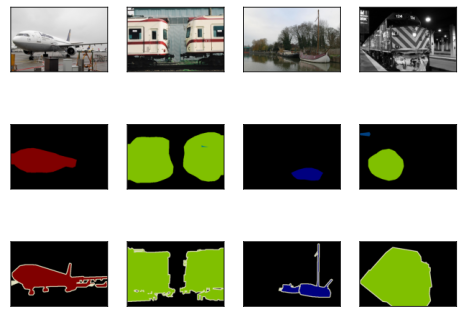

In [22]:
voc_dir = d2l.download_extract('voc2012', 'VOCdevkit/VOC2012')
test_images, test_labels = d2l.read_voc_images(voc_dir, False)
n, imgs = 4, []
for i in range(n):
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[i], *crop_rect)
    pred = label2image(predict(X))
    imgs += [X.permute(1,2,0), pred.cpu(),
             torchvision.transforms.functional.crop(
                 test_labels[i], *crop_rect).permute(1,2,0)]
d2l.show_images(imgs[::3] + imgs[1::3] + imgs[2::3], 3, n, scale=2);

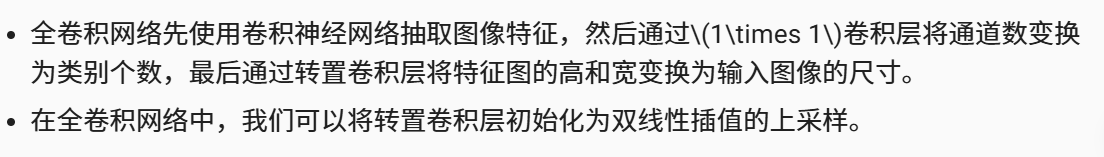